# Adaptive PDE discretizations on cartesian grids 
## Volume : Reproducible research
## Part : Eikonal CPU/GPU solvers comparison
## Chapter : Walls and obstacles

We compute minimal paths in domains featuring obstacles, and check that the CPU and GPU codes provide consistent results.

[**Summary**](Summary.ipynb) of volume Reproducible research, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Isotropic metrics](#1.-Isotropic-metrics)
  * [2. Curvature penalized metrics](#2.-Curvature-penalized-metrics)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research, 
some of it with PhD student Guillaume Bonnet, in co-direction with Frederic Bonnans.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..")
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Walls_GPU','Repro'))

In [3]:
from agd import AutomaticDifferentiation as ad
if ad.cupy_generic.cp is None: raise ad.DeliberateNotebookError('Cupy module required')
from agd import Eikonal
from agd import Metrics
from agd import FiniteDifferences as fd
from agd import LinearParallel as lp
import agd.AutomaticDifferentiation.cupy_generic as cugen
norm_infinity = ad.Optimization.norm_infinity

from agd.ExportedCode.Notebooks_Repro.Isotropic_GPU import RunCompare
from agd.ExportedCode.Notebooks_NonDiv.LinearMonotoneSchemes2D import streamplot_ij

In [4]:
import cupy as cp
import numpy as np
import itertools
from matplotlib import pyplot as plt
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%5.3g" % x))

In [5]:
cp = ad.functional.decorate_module_functions(cp,cugen.set_output_dtype32) # Use float32 and int32 types in place of float64 and int64
plt = ad.functional.decorate_module_functions(plt,cugen.cupy_get_args)
Eikonal.dictIn.default_mode = 'gpu'

### 0.1 Additional configuration

Run large problem instances (computation time may become a bit longer).

In [6]:
large_instances=True

## 1. Isotropic metrics

In [7]:
n=201
hfmIn = Eikonal.dictIn({
    'model':'Isotropic2',
    'seed':[0,0],
    'exportValues':1,
    'cost':1,
})
hfmIn.SetRect([[-1,1],[0,1]],dimx=n+1,sampleBoundary=True)
hfmIn['tips']=hfmIn.Grid(dims=(4,4)).reshape(2,-1).T

In [8]:
X = hfmIn.Grid()
walls = np.logical_and(X[0]==X[0,int(2*n/3)],X[1]<=2./3.)
hfmIn['walls']=walls

In [9]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.05352163314819336 seconds, and 11 iterations.
Post-Processing


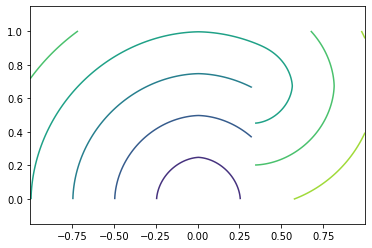

In [10]:
plt.axis('equal')
plt.contour(*X,hfmOut['values'])

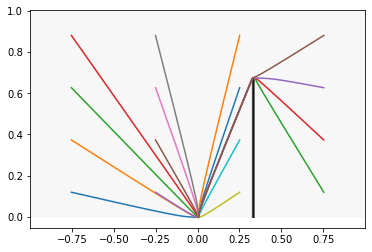

In [11]:
plt.contourf(*X,walls,cmap='Greys')
for geo in hfmOut['geodesics']: plt.plot(*geo)

In [12]:
assert all(stop=='AtSeed' for stop in hfmOut['geodesic_stopping_criteria'])

## 2. Curvature penalized metrics

In [13]:
n = 300 if large_instances else 100 
nTheta = 96 if large_instances else 64
hfmIn = Eikonal.dictIn({
    'model':'Elastica2',
    'seed':[0.,0.,np.pi],
    'exportValues':1,
    'cost':1,
    'xi':0.4,
    'count_updates':True,
#    'bound_active_blocks':True,
})
hfmIn.SetRect([[-1,1],[0,1]],dimx=n+1,sampleBoundary=True)
hfmIn.nTheta = nTheta

tips = hfmIn.Grid(dims=(4,4,4))
tips = np.moveaxis(tips.reshape(3,-1),0,-1)
hfmIn['tips'] = tips

In [14]:
X = hfmIn.Grid()
walls = np.logical_and(X[0]==X[0,int(2*n/3)],X[1]<=2./3.)
hfmIn['walls']=walls

In [15]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 1.0604908466339111 seconds, and 641 iterations.
Post-Processing


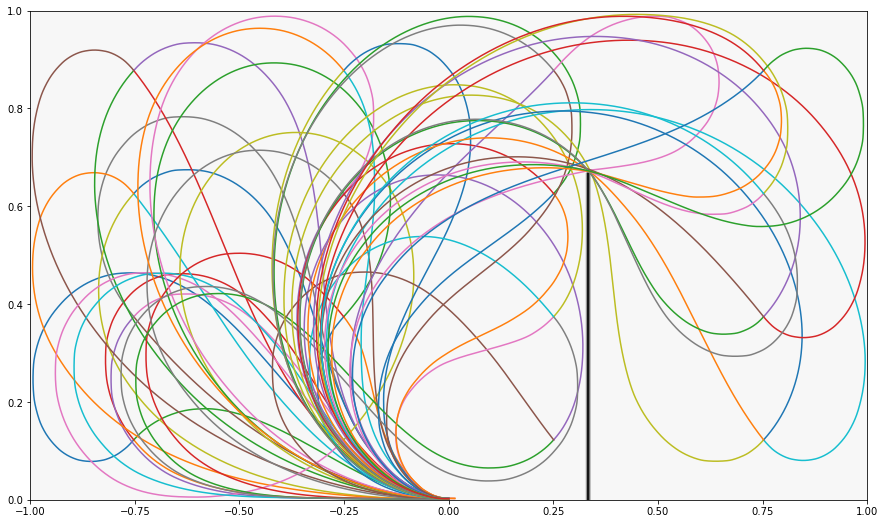

In [16]:
plt.figure(figsize=(15,9)) 
plt.contourf(*X[:2,:,:,0],walls[:,:,0],cmap='Greys')
for geo in hfmOut['geodesics']: plt.plot(*geo)

All the geodesics end at the seed, except one whose tip is very close to the wall, with an initial orientation headed straight into it. Its stopping criterion is 'InWall'.

In [19]:
assert all(stop in ('AtSeed','InWall','PastSeed') for stop in hfmOut['geodesic_stopping_criteria'])